In [152]:
import pandas as pd
import time as t
from copy import deepcopy
from tqdm import tqdm

from scipy.fft import fft, fftfreq

In [2]:
pd.to_datetime("2020-11-11 24:30:00")

ParserError: hour must be in 0..23: 2020-11-11 24:30:00

In [5]:
## Separate Date and Time
df = pd.read_csv("time-log-clean-anon.csv")
print(df[df["Time"]=="2021-04-13 03:00:00"])
print(df.iloc[114960:114980,:])
print(df.iloc[120070:120090,:])

df2 = deepcopy(df)
print(df2, "\n", df2.shape)
print(df2.columns)
print(df2["Time"].iloc[0], "\n====\n", type(df2["Time"].iloc[0]))
df2["Date"] = df2["Time"].apply(lambda x: x.split(" ")[0])
df2["Time"] = df2["Time"].apply(lambda x: x.split(" ")[1])
df2 = df2[["Date", "Time", "Activity"]]
print(df2)

Empty DataFrame
Columns: [Time, Activity]
Index: []
Empty DataFrame
Columns: [Time, Activity]
Index: []
Empty DataFrame
Columns: [Time, Activity]
Index: []
                      Time Activity
0      2020-11-11 08:30:00    break
1      2020-11-11 08:35:00    break
2      2020-11-11 08:40:00    break
3      2020-11-11 08:45:00    break
4      2020-11-11 08:50:00    break
...                    ...      ...
96299  2022-04-30 23:30:00    break
96300  2022-04-30 23:35:00    break
96301  2022-04-30 23:40:00    break
96302  2022-04-30 23:45:00    break
96303  2022-04-30 23:50:00    break

[96304 rows x 2 columns] 
 (96304, 2)
Index(['Time', 'Activity'], dtype='object')
2020-11-11 08:30:00 
====
 <class 'str'>
             Date      Time Activity
0      2020-11-11  08:30:00    break
1      2020-11-11  08:35:00    break
2      2020-11-11  08:40:00    break
3      2020-11-11  08:45:00    break
4      2020-11-11  08:50:00    break
...           ...       ...      ...
96299  2022-04-30  23:30:00  

In [6]:
df2.iloc[60045:60060,:]

,Date,Time,Activity
60045,2021-10-13,22:35:00,prep
60046,2021-10-13,22:40:00,prep
60047,2021-10-13,22:45:00,prep
60048,2021-10-13,22:50:00,break
60049,2021-10-13,22:55:00,break
60050,2021-10-13,23:00:00,break
60051,2021-10-14,07:50:00,break
60052,2021-10-14,07:55:00,break
60053,2021-10-14,08:00:00,prep
60054,2021-10-14,08:05:00,prep


In [7]:
## Testing
print(df2["Activity"].unique())
vals = ["date", 
 'break', 'breakfast', 'planning', '108', 'lunch', '131a', 'career', 'exercise',
 'dinner', 'CLA', 'fys', 'appt', 'help', 'prep', '165a', '141a', '131b', '154a',
 'UDCE', '302', '141b', '171', '106', '137', '167', 'bike', '168', 'walk', '131c',
 '010', '122a', 'bus', '135', '104', '141c', '130', '330', '141', '162', '160', '174']
tmp = {vals[i]:0 for i in range(len(vals))}  # https://www.geeksforgeeks.org/python-convert-a-list-to-dictionary/
print(tmp)
print(df2["Activity"].value_counts())

['break' 'breakfast' 'planning' '108' 'lunch' '131a' 'career' 'exercise'
 'dinner' 'CLA' 'fys' 'appt' 'help' 'prep' '165a' '141a' '131b' '154a'
 'UDCE' '302' '141b' '171' '106' '137' '167' 'bike' '168' 'walk' '131c'
 '010' '122a' 'bus' '135' '104' '141c' '130' '330' '141' '162' '160' '174']
{'date': 0, 'break': 0, 'breakfast': 0, 'planning': 0, '108': 0, 'lunch': 0, '131a': 0, 'career': 0, 'exercise': 0, 'dinner': 0, 'CLA': 0, 'fys': 0, 'appt': 0, 'help': 0, 'prep': 0, '165a': 0, '141a': 0, '131b': 0, '154a': 0, 'UDCE': 0, '302': 0, '141b': 0, '171': 0, '106': 0, '137': 0, '167': 0, 'bike': 0, '168': 0, 'walk': 0, '131c': 0, '010': 0, '122a': 0, 'bus': 0, '135': 0, '104': 0, '141c': 0, '130': 0, '330': 0, '141': 0, '162': 0, '160': 0, '174': 0}
break        34571
help         10119
career        9185
dinner        4727
lunch         3382
planning      3350
exercise      2669
131b          2390
bike          1977
171           1857
breakfast     1811
prep          1748
137           160

In [8]:
# Some times are messed up and not mult's of 5; find them
# There are also lots of breaks in the middle of the night...
# ...this is because pandas sometimes takes the long way around
for i, row in tqdm(df2.iterrows()):
    #if pd.to_datetime(row.Time).minute%5 != 0:
    if pd.to_datetime(row.Time).hour == 3:
        print(row.Date, row.Time)
        break

96304it [00:23, 4147.90it/s]


# EDA 

In [9]:
## By time of day:
by_min = pd.DataFrame()

# Group the data by time slot
for i, onetime in tqdm(df2.groupby("Time")):
    #print(i, type(i))
    result = {vals[i]:0 for i in range(len(vals))}
    for act in onetime["Activity"]: 
        result[act] += 1
    result["date"] = i
    by_min = by_min.append(result, ignore_index=True)
print(by_min.iloc[0,:])

100%|██████████| 251/251 [00:01<00:00, 140.95it/s]

010                 0
104                 1
106                 0
108                 0
122a                0
130                 0
131a                0
131b                0
131c                0
135                 0
137                 0
141                 0
141a                0
141b                0
141c                1
154a                0
160                 0
162                 0
165a                0
167                 0
168                 0
171                 0
174                 1
302                 0
330                 0
CLA                 0
UDCE                0
appt                0
bike                0
break              14
breakfast           0
bus                 0
career              0
date         00:00:00
dinner              0
exercise            0
fys                 0
help                0
lunch               0
planning            0
prep                0
walk                0
Name: 0, dtype: object


In [10]:
by_min = by_min.groupby(["date"]).sum()
# by_min.index.name = "Time"
by_min

,010,104,106,108,122a,130,131a,131b,131c,135,...,bus,career,dinner,exercise,fys,help,lunch,planning,prep,walk
date,,,,,,,,,,,,,,,,,,,,,
00:00:00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00:05:00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00:10:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
00:20:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23:35:00,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,4.0,1.0,0.0,0.0,4.0,0.0,3.0,2.0,0.0
23:40:00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,1.0,0.0,0.0,2.0,0.0,4.0,0.0,0.0
23:45:00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0


In [11]:
# Something is off, with breaks in the middle of the night
print(by_min.iloc[:10,:].sum())
print()

010           0.0
104           2.0
106           0.0
108           0.0
122a          0.0
130           0.0
131a          0.0
131b          0.0
131c          0.0
135           0.0
137           0.0
141           0.0
141a          0.0
141b          0.0
141c          2.0
154a          0.0
160           0.0
162           0.0
165a          0.0
167           0.0
168           0.0
171           0.0
174           8.0
302           0.0
330           0.0
CLA           0.0
UDCE          0.0
appt          0.0
bike          0.0
break        37.0
breakfast     0.0
bus           0.0
career        0.0
dinner        0.0
exercise      0.0
fys           0.0
help          0.0
lunch         0.0
planning      1.0
prep          2.0
walk          0.0
dtype: float64



41it [00:05,  7.09it/s]


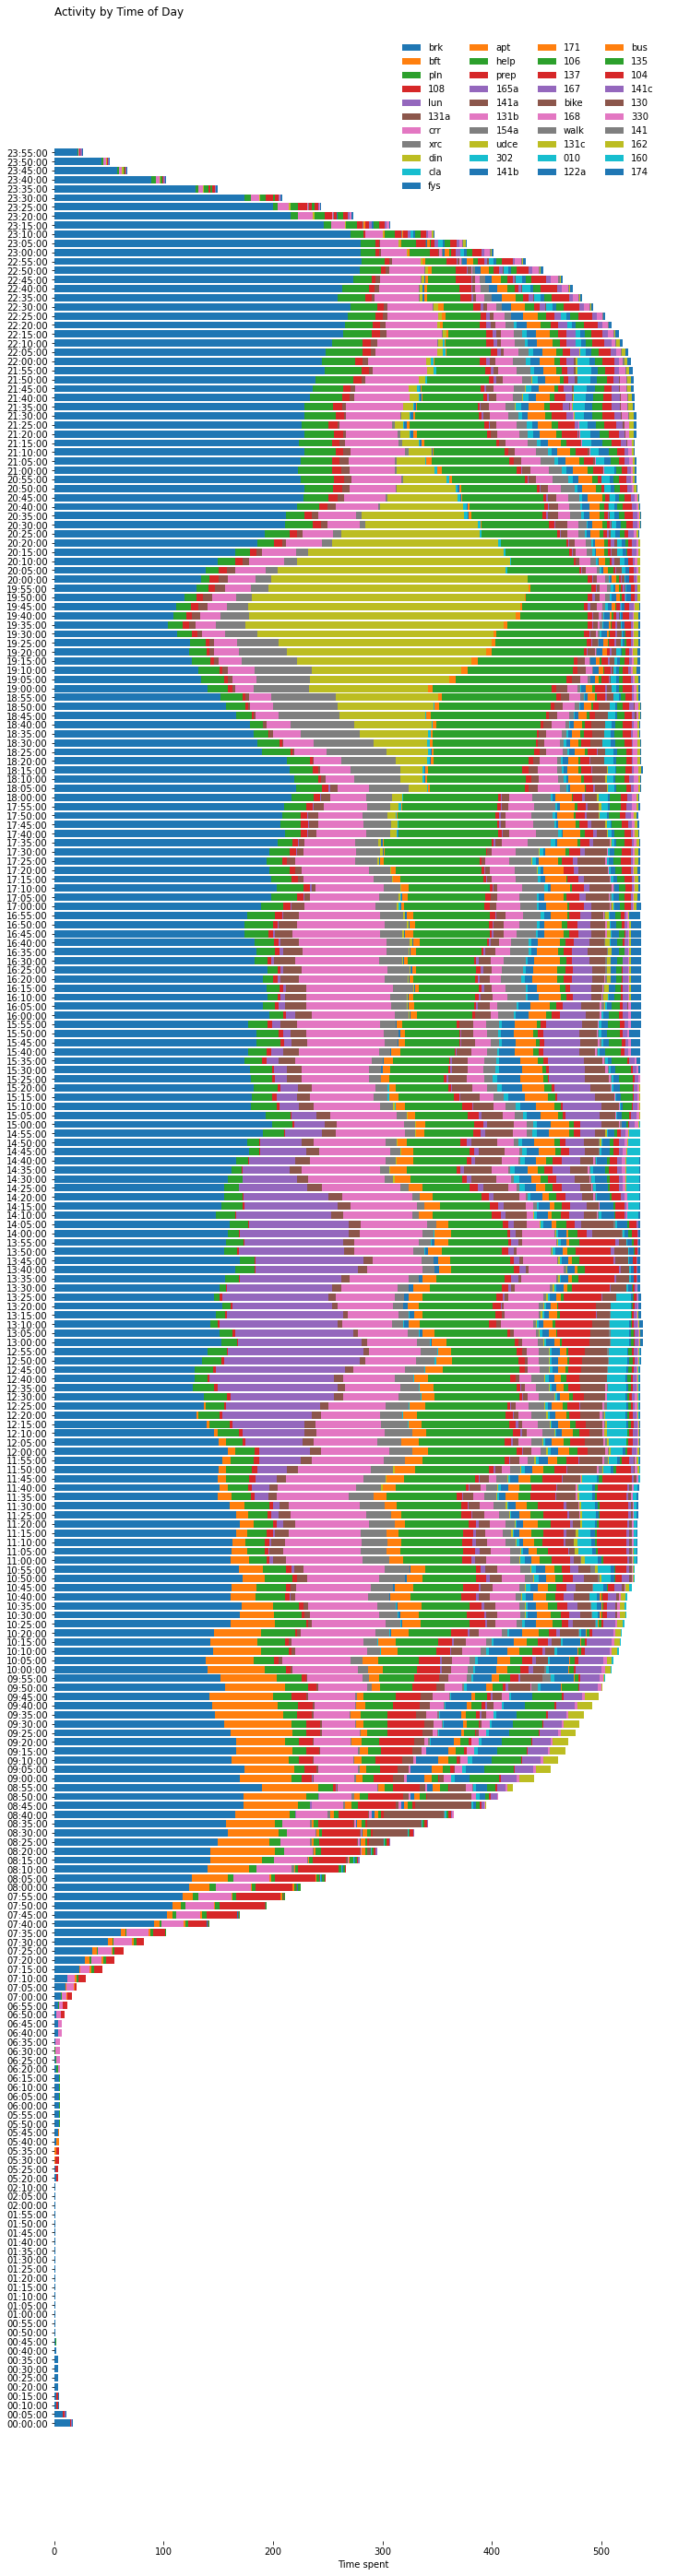

In [12]:
## =================  
# from https://towardsdatascience.com/stacked-bar-charts-with-pythons-matplotlib-f4020e4eb4a7

import matplotlib.pyplot as plt

fields = ['break', 'breakfast', 'planning', '108', 'lunch', '131a', 'career', 'exercise',
 'dinner', 'CLA', 'fys', 'appt', 'help', 'prep', '165a', '141a', '131b', '154a',
 'UDCE', '302', '141b', '171', '106', '137', '167', 'bike', '168', 'walk', '131c',
 '010', '122a', 'bus', '135', '104', '141c', '130', '330', '141', '162', '160', '174']
# TODO:
#colors = ['#1D2F6F', '#8390FA', '#6EAF46', '#FAC748']
labels = ['brk', 'bft', 'pln', '108', 'lun', '131a', 'crr', 'xrc',
 'din', 'cla', 'fys', 'apt', 'help', 'prep', '165a', '141a', '131b', '154a',
 'udce', '302', '141b', '171', '106', '137', '167', 'bike', '168', 'walk', '131c',
 '010', '122a', 'bus', '135', '104', '141c', '130', '330', '141', '162', '160', '174']
# figure and axis
fig, ax = plt.subplots(1, figsize=(12, 50))
# plot bars
left = len(by_min) * [0]
for idx, name in tqdm(enumerate(fields)):
    plt.barh(by_min.index, by_min[name], left = left) #, color=colors[idx])
    left = left + by_min[name]
# title, legend, labels
plt.title('Activity by Time of Day\n', loc='left')
plt.legend(labels, bbox_to_anchor=([0.55, 1, 0, 0]), ncol=4, frameon=False)
plt.xlabel('Time spent')
# remove spines
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# adjust limits and draw grid lines
# f = plt.figure()
# f.set_size_inches(10,120)
# plt.ylim(-0.5, ax.get_yticks()[-1] + 0.5)
# ax.set_axisbelow(True)
# ax.xaxis.grid(color='gray', linestyle='dashed')
fig.savefig('by_time_of_day.jpg', bbox_inches='tight', dpi=150)
plt.show()

In [13]:
by_min2 = (by_min.div(by_min.sum(axis=1), axis=0))
by_min2

,010,104,106,108,122a,130,131a,131b,131c,135,...,bus,career,dinner,exercise,fys,help,lunch,planning,prep,walk
date,,,,,,,,,,,,,,,,,,,,,
00:00:00,0.0,0.058824,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0
00:05:00,0.0,0.090909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0
00:10:00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.250000,0.0
00:15:00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.250000,0.0
00:20:00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23:35:00,0.0,0.020134,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006711,...,0.0,0.026846,0.006711,0.0,0.0,0.026846,0.0,0.020134,0.013423,0.0
23:40:00,0.0,0.009804,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.029412,0.009804,0.0,0.0,0.019608,0.0,0.039216,0.000000,0.0
23:45:00,0.0,0.014925,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.044776,0.014925,0.0,0.0,0.014925,0.0,0.029851,0.000000,0.0


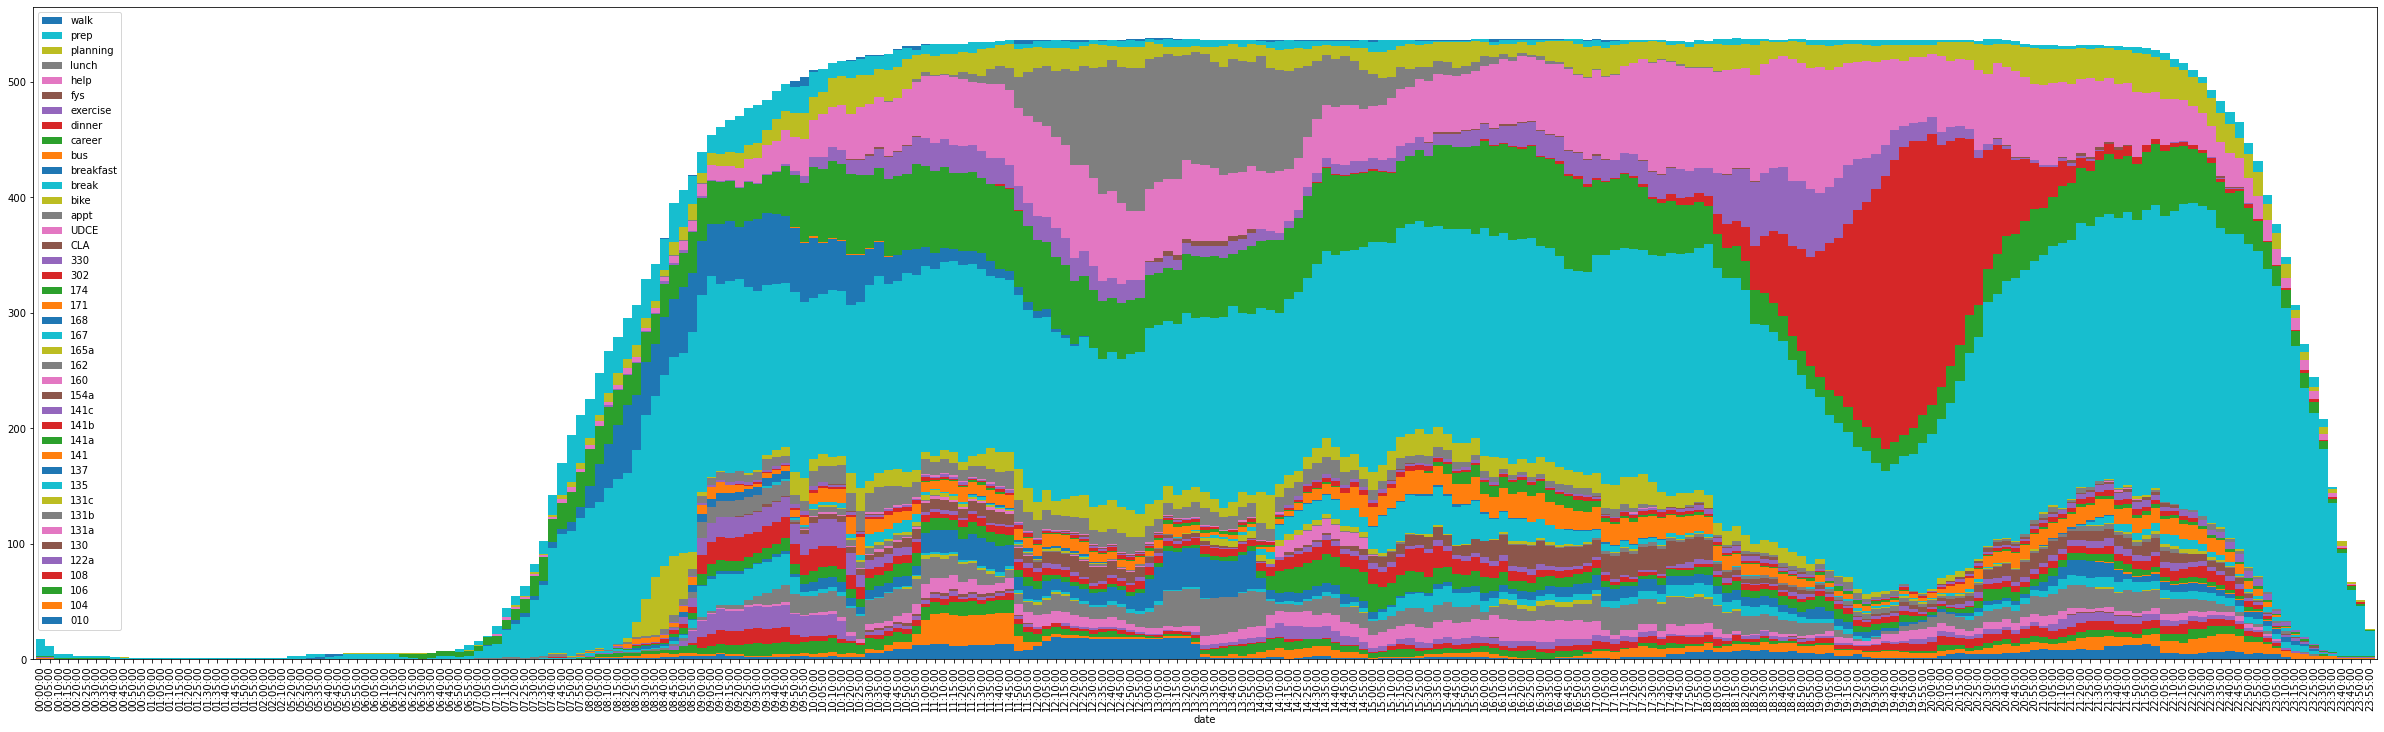

In [160]:
prop_bars = by_min.plot(kind='bar', stacked=True, figsize=(42,12), legend="reverse", width=1).get_figure()
prop_bars.savefig('./by_time_of_day0.png', bbox_inches='tight', dpi=150)

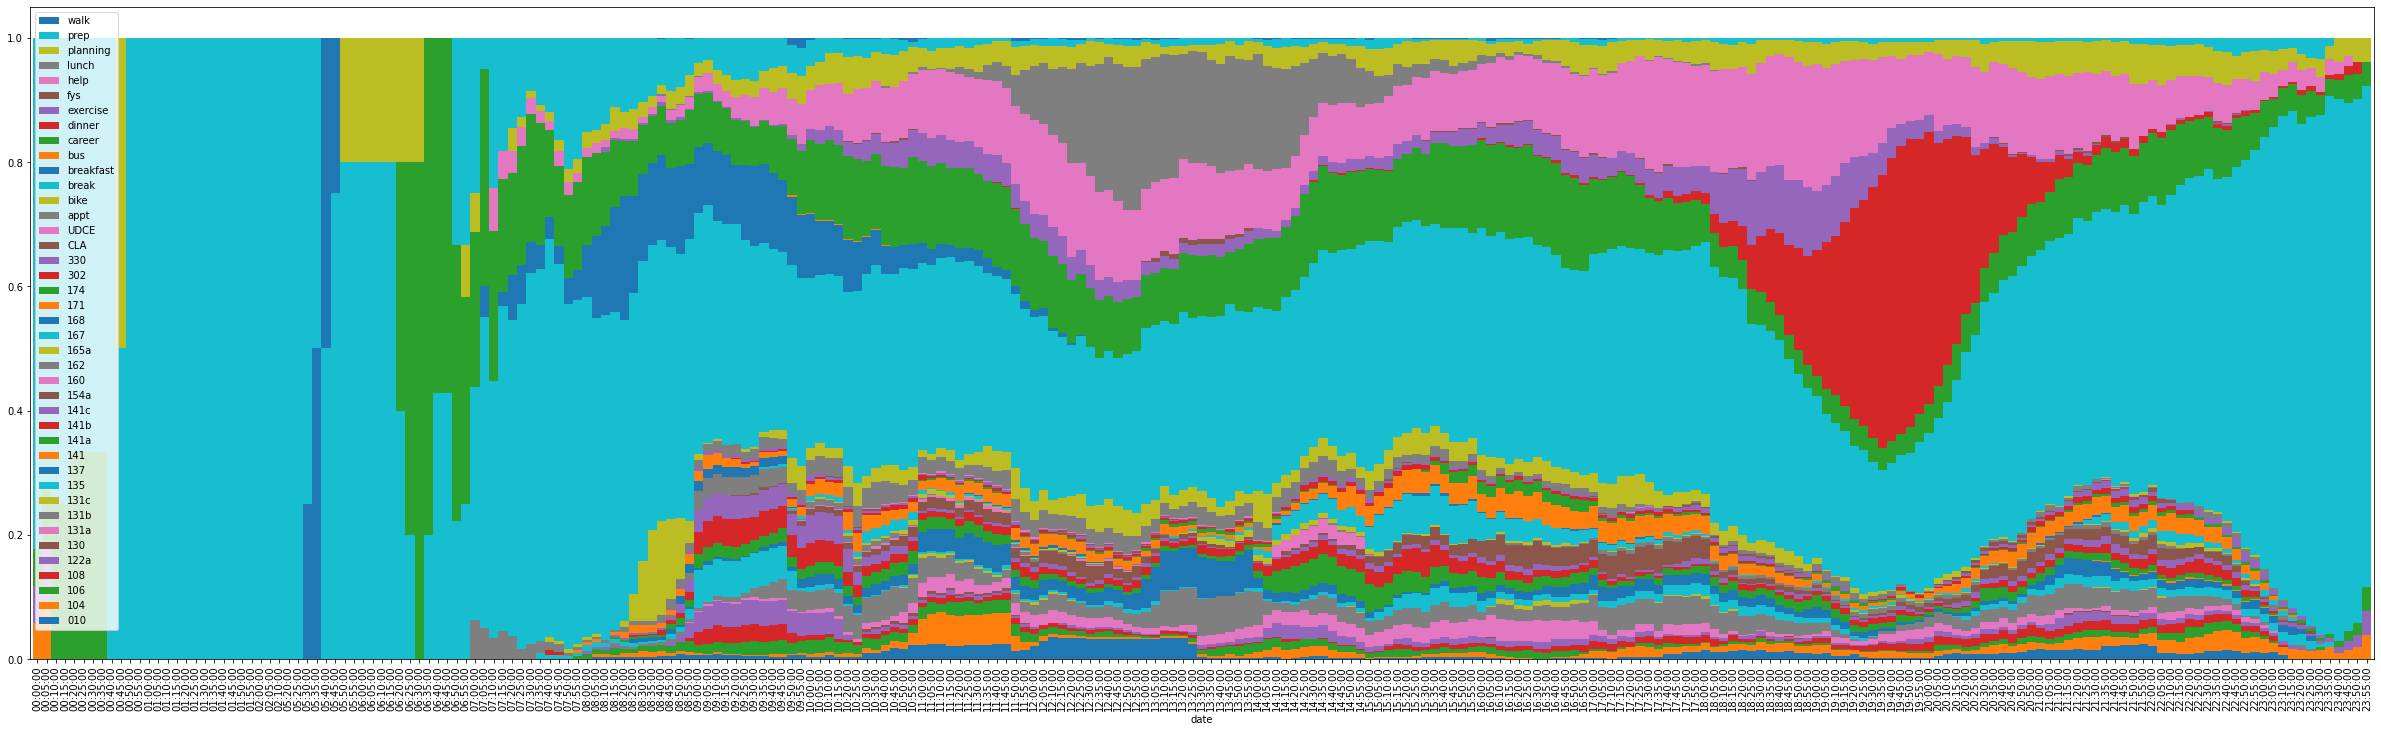

In [161]:
# Same graph as above, but with proportions and not counts
prop_bars = by_min2.plot(kind='bar', stacked=True, figsize=(42,12), legend="reverse", width=1).get_figure()
prop_bars.savefig('./by_time_of_day2.png', bbox_inches='tight', dpi=150)

# Just add a title and rotate the x-axis labels to be horizontal.
# plt.title('Tips by Day and Gender')
# plt.xticks(rotation=0, ha='center')

In [15]:
test = pd.DataFrame(([[1,0], [3,4]])); print(test, "\n")
test[2] = test[[0,1]].apply(lambda x: sum(x), axis=1)
print(test)

   0  1
0  1  0
1  3  4 

   0  1  2
0  1  0  1
1  3  4  7


{'appt', 'lunch', 'dinner', 'walk', 'planning', 'breakfast', 'bike', 'career', 'break', 'bus', 'prep', 'help', 'exercise'}
          planning  lunch     break  exercise  appt    dinner  bike  \
date                                                                  
00:00:00  0.000000    0.0  0.823529       0.0   0.0  0.000000   0.0   
00:05:00  0.000000    0.0  0.727273       0.0   0.0  0.000000   0.0   
00:10:00  0.000000    0.0  0.500000       0.0   0.0  0.000000   0.0   
00:15:00  0.000000    0.0  0.500000       0.0   0.0  0.000000   0.0   
00:20:00  0.000000    0.0  0.666667       0.0   0.0  0.000000   0.0   
...            ...    ...       ...       ...   ...       ...   ...   
23:35:00  0.020134    0.0  0.865772       0.0   0.0  0.006711   0.0   
23:40:00  0.039216    0.0  0.872549       0.0   0.0  0.009804   0.0   
23:45:00  0.029851    0.0  0.850746       0.0   0.0  0.014925   0.0   
23:50:00  0.039216    0.0  0.843137       0.0   0.0  0.019608   0.0   
23:55:00  0.038462    0.0

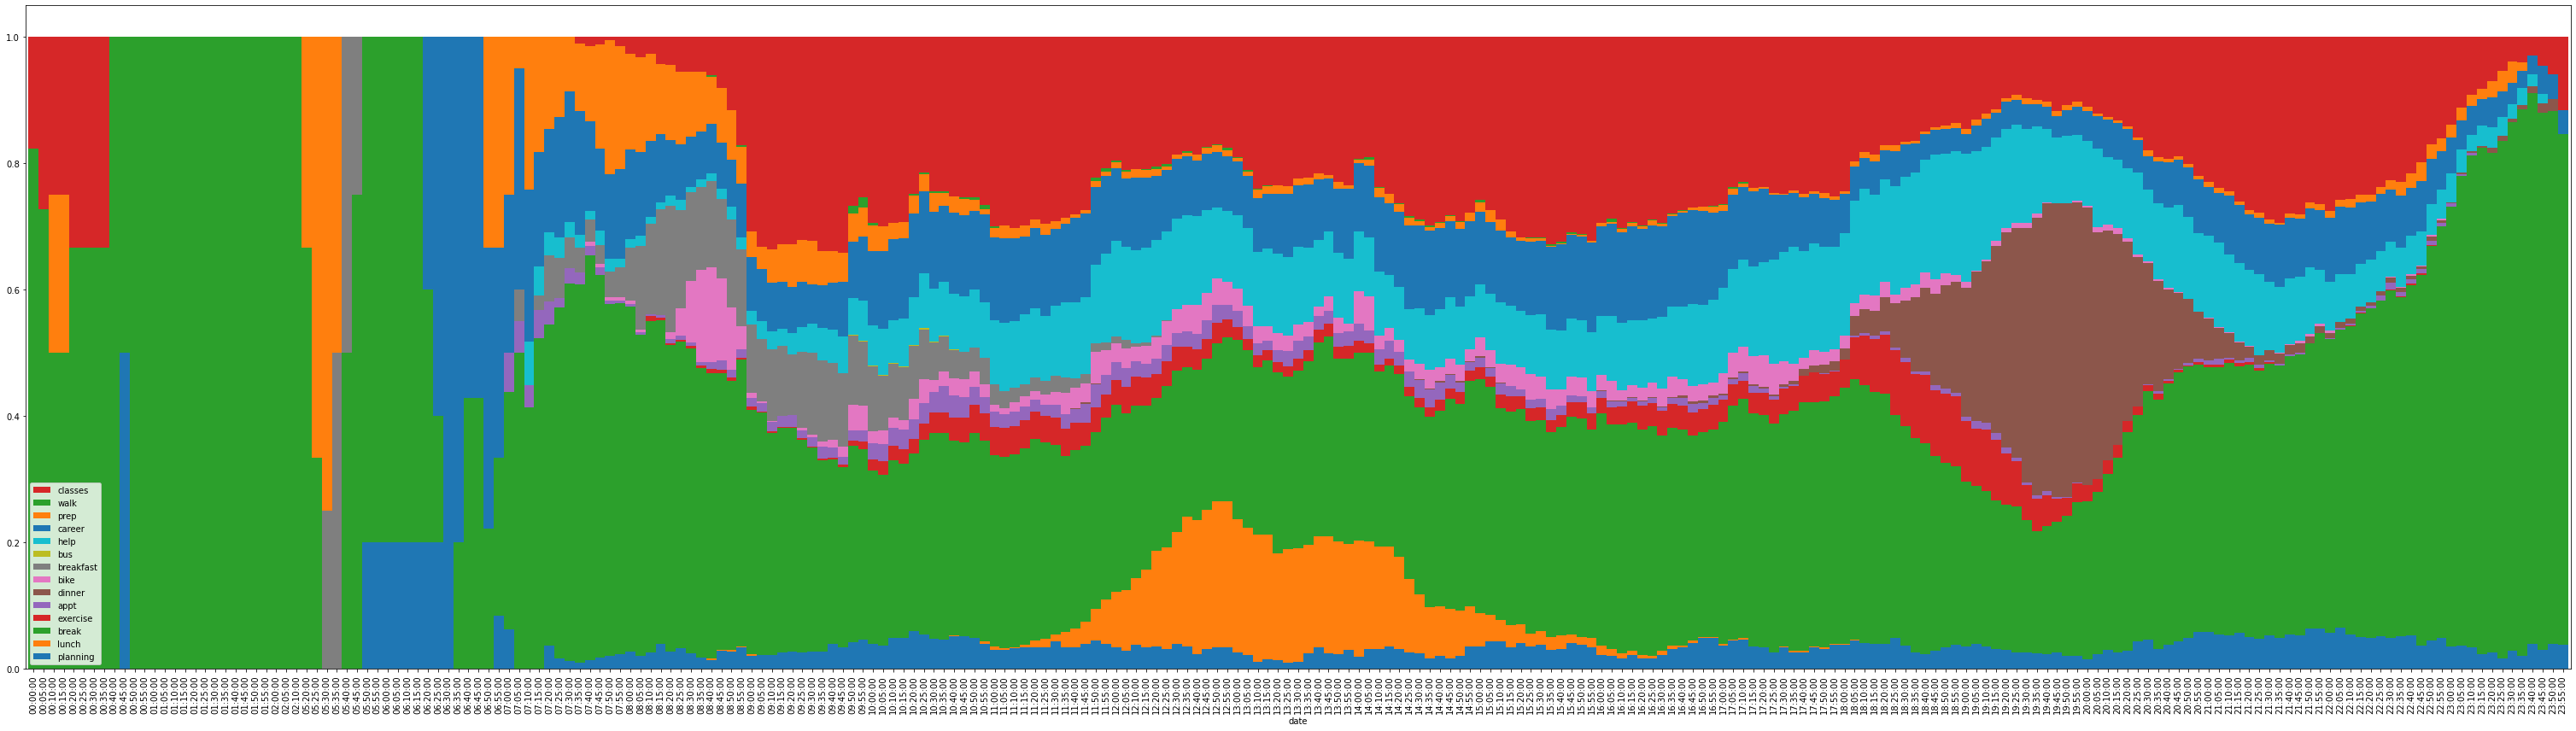

In [163]:
# Same graph as above, but with one class category and not multiple
classes = ['UDCE', '141b', '104', '135', '108', '137', '162', '171', '122a', '174', '131a', '168','167', 'CLA', 'fys', '330', '154a', '141a', '302', '130', '141c', '165a', '131c', '160', '141', '131b', '010', '106']
print(set(by_min2.columns)-set(classes))
nonclasses = ['planning', 'lunch', 'break', 'exercise', 'appt', 'dinner', 'bike', 'breakfast', 'bus', 'help', 'career', 'prep', 'walk']
nonclasses.extend(["classes"])

by_min3 = deepcopy(by_min2)
by_min3["classes"] = by_min2[classes].apply(lambda x: sum(x), axis=1)
by_min3 = by_min3[nonclasses]
print(by_min3)

prop_bars = by_min3.plot(kind='bar', stacked=True, figsize=(42,12), legend="reverse", width=1).get_figure()
plt.tight_layout()
prop_bars.savefig('./by_time_of_day3.png', bbox_inches='tight', dpi=150)

In [ ]:
## By week or month: 

# Path 1: Full dataset, using time series analysis

(these bullet points can apply to Path 2 as well, and v.v.)

- find proportion of time spent in each 5-minute period

- perform spectral analysis/Fourier transform to see underlying patterns

In [ ]:
# yf = fft(normalized_tone)
# xf = fftfreq(N, 1 / SAMPLE_RATE)

# plt.plot(xf, np.abs(yf))
# plt.show()

# Path 2: Shortened dataset (with extracted features)

- run ML methods to determine patterns and groupings

- do hierarchical clustering to find ideal bins, and perform binning to investigate conclusions from health/psychology/other research

- track changes over the entire year? 

In [53]:
print(1 if pd.Timestamp("2020-11-15").weekday()>=5 else 0)
print(1 if pd.Timestamp("2020-11-11").weekday()>=5 else 0)

1
0


In [146]:
daybyday = pd.DataFrame()
for row in tqdm(df2.groupby("Date")):
    #print(row[0])
    #print(row[1])
    oneday = row[1]
    result = {vals[i]:0 for i in range(len(vals))}
    for x in oneday["Activity"]:
        result[x] += 1
    result["date"] = row[0]
    result["actualday"] = pd.Timestamp(row[0]).weekday()
    result["weekend"] = 1 if pd.Timestamp(row[0]).weekday()>=5 else 0
    
    ## Find totals (for morning/afternoon/evening)
#     for i,x in oneday.iterrows():
#         #print(x.Time)
#         print(type(x))
    prelunch = oneday[oneday.Time < "13:00:00"]
    prelunch_br = prelunch[prelunch["Activity"] == "break"].shape[0]
    prelunch_nbr = prelunch[prelunch["Activity"] != "break"].shape[0]
    tmp = oneday[oneday.Time >= "13:00:00"]
    afterlunch = tmp[tmp.Time < "19:00:00"]
    afterlunch_br = afterlunch[afterlunch["Activity"] == "break"].shape[0]
    afterlunch_nbr = afterlunch[afterlunch["Activity"] != "break"].shape[0]
    evening = oneday[oneday.Time >= "19:00:00"]
    afterdin_br = evening[evening["Activity"] == "break"].shape[0]
    afterdin_nbr = evening[evening["Activity"] != "break"].shape[0]
    result["beforelunch_break"] = prelunch_br
    result["beforelunch_nonbreak"] = prelunch_nbr
    result["afterlunch_break"] = afterlunch_br
    result["afterlunch_nonbreak"] = afterlunch_nbr
    result["afterdinner_break"] = afterdin_br
    result["afterdinner_nonbreak"] = afterdin_nbr
    
    ## Find early day statistics
    morningbr = 0
    earliesttime = oneday["Time"].iloc[0]
    getuptime = None
    for i,x in oneday.iterrows():
        if(x.Activity != "break"):
            getuptime = x.Time
            break
        else:
            morningbr += 1
    ## Reverse df, and find late day stats
    eveningbr = 0
    latesttime = list(oneday.iloc[::-1]["Time"])[0]
    lastnonbreak = None
    for i,x in oneday.iloc[::-1].iterrows():
        #print(x)
        if(x.Activity != "break"):
            lastnonbreak = x.Time
            break
        else:
            eveningbr += 1
            
    result["wakeup"] = earliesttime
    result["getup"] = getuptime
    result["wakeup_breaks"] = morningbr
    result["bedtime"] = latesttime
    result["last_productive"] = lastnonbreak
    result["bedtime_breaks"] = eveningbr
    
    total_nonbr = oneday[oneday["Activity"] != "break"].shape[0]
    result["total_productive"] = total_nonbr
    
    ## Find class total
    #print(sum([1 if x in classes else 0 for x in list(oneday["Activity"])]))
    class_tot = sum([1 if x in classes else 0 for x in list(oneday["Activity"])])
    result["total_class_time"] = class_tot
    #print(result)
    daybyday = daybyday.append(result, ignore_index=True)

100%|██████████| 536/536 [00:10<00:00, 51.97it/s]


In [147]:
# Get the previous day's bedtime and determine sleep as well
daybyday["prev_bedtime"] = daybyday.bedtime.shift(1)
# daybyday["sleep_incl_prep"] = daybyday["wakeup"] - daybyday["prev_bedtime"]

In [148]:
## Testing prev. 
# pd.DateOffset(1)
list(daybyday["prev_bedtime"].apply(lambda x: pd.to_datetime(x) - pd.DateOffset(1)))[1]

Timestamp('2022-06-03 22:45:00')

In [149]:
s = (daybyday["wakeup"].apply(lambda x: pd.to_datetime(x)) - (daybyday["prev_bedtime"].apply(lambda x: pd.to_datetime(x) - pd.DateOffset(1))))
print(s)

0                 NaT
1     0 days 09:45:00
2     0 days 08:45:00
3     0 days 11:40:00
4     0 days 09:25:00
            ...      
531   0 days 06:55:00
532   0 days 08:40:00
533   0 days 07:30:00
534   0 days 08:10:00
535   0 days 09:05:00
Length: 536, dtype: timedelta64[ns]


In [150]:
ordered = ["date"]
ordered.extend([x for x in list(set(daybyday.columns)-set(["date"]))])
print(ordered)
daybyday = daybyday[ordered]
daybyday = daybyday.drop(classes, axis=1)
daybyday["sleep_incl_prep"] = (daybyday["wakeup"].apply(lambda x: pd.to_datetime(x)) - (daybyday["prev_bedtime"].apply(lambda x: pd.to_datetime(x) - pd.DateOffset(1))))
daybyday = daybyday.dropna()
print(daybyday.columns)
daybyday.to_csv("./time-log-shortened.csv")

['date', 'getup', 'dinner', 'total_productive', 'weekend', '167', 'afterdinner_break', '137', 'help', 'wakeup_breaks', '130', 'last_productive', 'exercise', '165a', 'prev_bedtime', '131a', '131b', '171', 'walk', '108', 'breakfast', '141a', '131c', 'fys', '106', '168', '141', '010', '135', 'total_class_time', 'lunch', '302', 'UDCE', 'bedtime', '174', '122a', 'bike', 'career', '141b', 'afterlunch_break', 'afterlunch_nonbreak', 'bedtime_breaks', 'prep', '160', '141c', 'beforelunch_break', 'CLA', 'appt', '104', 'beforelunch_nonbreak', 'wakeup', 'break', 'bus', 'afterdinner_nonbreak', 'actualday', '154a', 'planning', '330', '162']
Index(['date', 'getup', 'dinner', 'total_productive', 'weekend',
       'afterdinner_break', 'help', 'wakeup_breaks', 'last_productive',
       'exercise', 'prev_bedtime', 'walk', 'breakfast', 'total_class_time',
       'lunch', 'bedtime', 'bike', 'career', 'afterlunch_break',
       'afterlunch_nonbreak', 'bedtime_breaks', 'prep', 'beforelunch_break',
       'app

In [151]:
daybyday.iloc[250:260,:]

,date,getup,dinner,total_productive,weekend,afterdinner_break,help,wakeup_breaks,last_productive,exercise,...,beforelunch_break,appt,beforelunch_nonbreak,wakeup,break,bus,afterdinner_nonbreak,actualday,planning,sleep_incl_prep
251,2021-07-20,07:45:00,6.0,106.0,0.0,30.0,21.0,7.0,22:50:00,13.0,...,30.0,0.0,40.0,07:10:00,93.0,0.0,27.0,1.0,0.0,0 days 07:25:00
252,2021-07-21,07:20:00,19.0,153.0,0.0,9.0,15.0,0.0,23:25:00,0.0,...,8.0,0.0,60.0,07:20:00,42.0,0.0,46.0,2.0,1.0,0 days 07:40:00
253,2021-07-22,09:00:00,8.0,98.0,0.0,31.0,36.0,4.0,21:15:00,0.0,...,4.0,0.0,48.0,08:40:00,85.0,0.0,28.0,3.0,2.0,0 days 09:10:00
254,2021-07-23,09:40:00,16.0,95.0,0.0,31.0,46.0,13.0,22:25:00,0.0,...,18.0,0.0,35.0,08:35:00,82.0,0.0,21.0,4.0,1.0,0 days 08:45:00
255,2021-07-24,09:40:00,8.0,117.0,1.0,27.0,101.0,14.0,22:30:00,0.0,...,14.0,0.0,40.0,08:30:00,64.0,0.0,28.0,5.0,3.0,0 days 09:15:00
256,2021-07-25,09:45:00,9.0,144.0,1.0,22.0,130.0,8.0,22:15:00,0.0,...,8.0,0.0,39.0,09:05:00,30.0,0.0,33.0,6.0,0.0,0 days 09:35:00
257,2021-07-26,09:35:00,15.0,90.0,0.0,28.0,31.0,7.0,23:10:00,0.0,...,16.0,0.0,32.0,09:00:00,90.0,0.0,32.0,0.0,0.0,0 days 09:30:00
258,2021-07-27,07:50:00,8.0,113.0,0.0,45.0,69.0,0.0,19:55:00,0.0,...,18.0,0.0,44.0,07:50:00,78.0,0.0,12.0,1.0,0.0,0 days 07:55:00
259,2021-07-28,07:45:00,12.0,81.0,0.0,30.0,43.0,0.0,23:20:00,0.0,...,29.0,0.0,34.0,07:45:00,109.0,0.0,25.0,2.0,0.0,0 days 08:05:00
260,2021-07-29,08:25:00,8.0,78.0,0.0,36.0,14.0,13.0,22:55:00,0.0,...,45.0,9.0,23.0,07:20:00,110.0,0.0,12.0,3.0,6.0,0 days 07:50:00
